In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import scipy.stats as stats
from scipy import interp
import statistics 
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from statistics import mean 


from sklearn import metrics
from sklearn.metrics import auc
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import log_loss
from sklearn.impute import SimpleImputer


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneOut 


from xgboost.sklearn import XGBClassifier

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier

# other tools
from functools import reduce
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN # doctest: +NORMALIZE_WHITESPACE
import itertools
import copy

import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline

np.random.seed(100)

# df0 = pd.read_csv('Diabetes Project Part 2.csv')
# df = df0.copy(deep=True)
# df.head()

In [15]:
df = pd.read_csv('Diabetes Data.csv')
df = df.drop(['Unnamed: 0'],axis=1)
df.head()

,Anemia,BMI,HDL,LDL,Pesticide Use,Age,Alcohol Use,Diabetes,Exercise,Fasting Glucose,...,Insulin_NaN,SysBP_NaN,DiaBP_NaN,Alcohol Use_NaN,Mexican American,Hispanic,White,Black,Asian,Other Race
0,0.0,-1.624450,1.814557,-0.288805,0.0,1.399115,-1.061516,0.0,1.0,0.377156,...,0,0,0,0,0,0,1,0,0,0
1,0.0,1.183858,0.284185,-0.416550,0.0,0.729447,-0.368968,0.0,1.0,0.574394,...,0,0,0,0,0,0,1,0,0,0
2,0.0,-1.482733,2.334568,-1.368495,0.0,-1.223751,-0.368968,0.0,1.0,-0.942001,...,0,0,0,0,0,0,1,0,0,0
3,0.0,0.185727,-1.582470,0.282361,0.0,-0.888917,5.863966,0.0,0.0,0.173088,...,0,0,0,0,1,0,0,0,0,0
4,0.0,1.210246,0.082563,1.553668,0.0,-0.554083,-0.715242,0.0,0.0,0.104585,...,0,1,1,0,0,0,0,1,0,0


In [16]:
# y = df['Diabetes'].values
# X = df.drop(['Diabetes'],axis = 1).values
y = df['Diabetes']
X = df.drop(['Diabetes'],axis = 1)
X_names = df.drop(['Diabetes'],axis = 1).columns.tolist()
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state = 2)


In [17]:
numerical_variables = ['BMI','HDL','LDL','Age','Alcohol Use','Fasting Glucose','Insulin','sysBP','diaBP',
                       'Leg Length','Waist Size']
categorical_variables = ['Mexican American','Hispanic','White','Black','Asian','Other Race',
                          'BMI_NaN','Fasting glucose_NaN','LDL_NaN','HDL_NaN','Insulin_NaN',
                          'SysBP_NaN','DiaBP_NaN','Alcohol Use_NaN',
                         'Gender', 'Exercise', 'Pesticide Use','Anemia']
feature_list = numerical_variables + categorical_variables
len(feature_list)


29

In [18]:
def plot_roc(y_val,y_val_predictions,best_clf,X_val):
    probability = best_clf.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_val_predictions)
    print('AUC: = %0.2f' % roc_auc)
    fpr, tpr, thresholds = roc_curve(y_val, probability)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate - False alarm')
    plt.ylabel('True Positive Rate - Recall')
#     plt.title(clf_name + '  --  AUC: = %0.2f' % roc_auc)
    plt.legend(['ROC','Completely random'],loc="lower right")
    plt.show()

def roc_auc_score(y_val, y_val_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_val_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    return roc_auc

In [19]:
def plot_confusion_matrix(y_val, y_val_predictions):
    cm = metrics.confusion_matrix(y_val, y_val_predictions)

    class_names=[0,1] 
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [20]:
# Create a series with feature importances:
def feature_importance(best_clf,X_names):
    featimp = pd.Series(best_clf.feature_importances_,index=X_names).sort_values(ascending=False)
    print('feature importance')
    print(featimp)
    sns.barplot(x=featimp, y=featimp.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()
    return featimp


In [21]:
def no_cv(clf, X_train, y_train, X_val, y_val):    
    
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    roc_auc = roc_auc_score(y_val, y_val_pred)
    
    print()
    print('Train')
    print(classification_report(y_train, y_train_pred,target_names=['healthy','mentally ill']))
    print('Val')
    print(classification_report(y_val, y_val_pred,target_names=['healthy','mentally ill']))
    print('Logloss: %.2f' % log_loss(y_val, y_val_pred))
    print('roc auc:', roc_auc)
    
    return clf

def cv(clf, X_train_val, y_train_val):
    inner_cv = StratifiedKFold(n_splits=10,random_state=0,shuffle=True)
    
    accuracy_scores = cross_val_score(clf, X_train_val, y_train_val, cv=10, scoring = 'accuracy')
    precision_scores = cross_val_score(clf, X_train_val, y_train_val, cv=10, scoring = 'precision')
    recall_scores = cross_val_score(clf, X_train_val, y_train_val, cv=10, scoring = 'recall')

#     y_train_val_pred = cross_val_predict(clf, X_train_val, y_train_val)[:,1]


    print('accuracy')
    print(mean(accuracy_scores))
    print(accuracy_scores)
    print('recall')
    print(mean(recall_scores))
    print(recall_scores)
    print('precision')
    print(mean(precision_scores))
    print(precision_scores)
#     print("ROC-AUC score: {}".format(roc_auc_score(y_train_val, y_train_val_pred)))

    

In [22]:
def hyperparameters(clf, method, grid):
    
    if method == 'random':
        clf_search = RandomizedSearchCV(clf, param_distributions = grid, verbose=2, random_state=42, n_jobs = -1)
    elif method == 'gridsearch':
        clf_search = GridSearchCV(clf, param_grid = grid, n_jobs = -1,scoring = 'f1', refit = True)
    else: 
        print('not included')
    
    return clf_search


#### Attempt 1: unselected features + random forest ( already selected)

In [23]:
sm = SMOTE(random_state=42)
rf = RandomForestClassifier(random_state = 42, criterion= 'gini')

pipeline1 = Pipeline([('sm', sm), 
                      ('rf', rf)])

no_cv(pipeline1, X_train, y_train, X_val, y_val)


Train
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00      2542
mentally ill       1.00      0.99      0.99       262

    accuracy                           1.00      2804
   macro avg       1.00      0.99      1.00      2804
weighted avg       1.00      1.00      1.00      2804

Val
              precision    recall  f1-score   support

     healthy       0.95      0.96      0.95       635
mentally ill       0.56      0.48      0.52        66

    accuracy                           0.92       701
   macro avg       0.75      0.72      0.74       701
weighted avg       0.91      0.92      0.91       701

Logloss: 2.91
roc auc: 0.7227392030541636


Pipeline(memory=None,
         steps=[('sm',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('rf',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                      

In [24]:
cv(pipeline1, X_train_val, y_train_val)

accuracy
0.9124067111918115
[0.91168091 0.91737892 0.91737892 0.91452991 0.94017094 0.89458689
 0.9031339  0.90285714 0.90544413 0.91690544]
recall
0.42045454545454547
[0.45454545 0.42424242 0.45454545 0.54545455 0.51515152 0.3030303
 0.33333333 0.42424242 0.40625    0.34375   ]
precision
0.5452267520976587
[0.53571429 0.58333333 0.57692308 0.54545455 0.77272727 0.41666667
 0.47826087 0.48275862 0.48148148 0.57894737]


In [25]:
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 105, num = 10)]
# max_features = list(range(1,X_train.shape[1]))
max_features = ['sqrt','log2',None]
max_depth = [int(x) for x in np.linspace(10, 50, num = 10)]
min_samples_split = [10,20,30,40,50]
min_samples_leaf = [10,20,30,40,50] 
bootstrap = [True]

rf_grid =  {'rf__bootstrap': bootstrap,
            'rf__max_depth': max_depth,
            'rf__max_features': max_features,
            'rf__min_samples_leaf': min_samples_leaf,
            'rf__min_samples_split': min_samples_split,
            'rf__n_estimators': n_estimators}

In [26]:
best_rf = hyperparameters(pipeline1,'random',rf_grid) 
no_cv(best_rf, X_train, y_train, X_val, y_val)
# cv(best_rf, X_train_val, y_train_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.7s finished



Train
              precision    recall  f1-score   support

     healthy       0.98      0.97      0.97      2542
mentally ill       0.71      0.83      0.77       262

    accuracy                           0.95      2804
   macro avg       0.85      0.90      0.87      2804
weighted avg       0.96      0.95      0.95      2804

Val
              precision    recall  f1-score   support

     healthy       0.96      0.94      0.95       635
mentally ill       0.54      0.62      0.58        66

    accuracy                           0.91       701
   macro avg       0.75      0.78      0.76       701
weighted avg       0.92      0.91      0.92       701

Logloss: 2.96
roc auc: 0.7830470054879503


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('sm',
                                              SMOTE(k_neighbors=5,
                                                    kind='deprecated',
                                                    m_neighbors='deprecated',
                                                    n_jobs=1,
                                                    out_step='deprecated',
                                                    random_state=42, ratio=None,
                                                    sampling_strategy='auto',
                                                    svm_estimator='deprecated')),
                                             ('rf',
                                              RandomForestClassifier(bootstrap=True,
                                                                     class_weight=None,
               

In [27]:
cv(best_rf, X_train_val, y_train_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.1s finished


accuracy
0.9021217456002556
[0.8974359  0.92592593 0.92022792 0.90598291 0.93162393 0.88319088
 0.89173789 0.88285714 0.88825215 0.89398281]
recall
0.5911931818181818
[0.57575758 0.63636364 0.63636364 0.75757576 0.66666667 0.51515152
 0.60606061 0.42424242 0.53125    0.5625    ]
precision
0.48513074049659416
[0.46341463 0.6        0.56756757 0.5        0.62857143 0.4047619
 0.44444444 0.38888889 0.41463415 0.43902439]


In [28]:
print("Best Parameters: {}".format(best_rf.best_params_))
best_rf = best_rf.best_estimator_

Best Parameters: {'rf__n_estimators': 60, 'rf__min_samples_split': 20, 'rf__min_samples_leaf': 10, 'rf__max_features': 'log2', 'rf__max_depth': 45, 'rf__bootstrap': True}


In [29]:
best_rf[1]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=45, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

feature importance
Fasting Glucose        0.212009
Age                    0.202671
Exercise               0.114124
LDL                    0.063996
Waist Size             0.044843
sysBP                  0.037866
Gender                 0.035357
White                  0.035119
Leg Length             0.029244
Alcohol Use            0.027004
BMI                    0.024350
Insulin                0.023113
HDL                    0.022625
diaBP                  0.019520
Alcohol Use_NaN        0.016135
Black                  0.016101
Mexican American       0.015956
Hispanic               0.013886
Pesticide Use          0.009171
Asian                  0.008892
Anemia                 0.006015
SysBP_NaN              0.005701
DiaBP_NaN              0.005004
HDL_NaN                0.003062
Insulin_NaN            0.002964
LDL_NaN                0.002713
Fasting glucose_NaN    0.001979
Other Race             0.000310
BMI_NaN                0.000268
dtype: float64


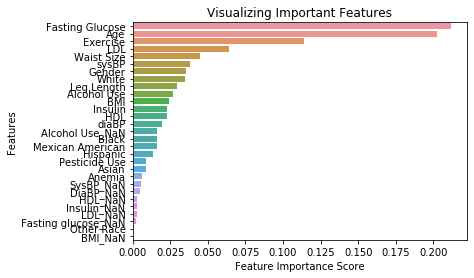

In [30]:
featimp = feature_importance(best_rf[1],X_names)

In [31]:
important_features = []
for feature, value in featimp.items():
    if value>0.01:
        important_features.append(feature)

# this time only use important features to rebuild rf see if it changes the result by much
dfxtrain = pd.DataFrame(X_train.values,columns = [X_names]) # original df X_train
dfxval = pd.DataFrame(X_val.values,columns = [X_names])     # original df X_val

X_train_imp = dfxtrain[important_features]
X_val_imp = dfxval[important_features]

dfxtrainval = pd.DataFrame(X_train_val.values,columns = [X_names])     # original df X_val
X_train_val_imp = dfxtrainval[important_features]

In [32]:
best_rf = hyperparameters(pipeline1,'random',rf_grid)
best_rf_final = no_cv(best_rf, X_train_imp, y_train, X_val_imp, y_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.1s finished



Train
              precision    recall  f1-score   support

     healthy       0.98      0.96      0.97      2542
mentally ill       0.69      0.84      0.76       262

    accuracy                           0.95      2804
   macro avg       0.84      0.90      0.87      2804
weighted avg       0.96      0.95      0.95      2804

Val
              precision    recall  f1-score   support

     healthy       0.96      0.94      0.95       635
mentally ill       0.51      0.65      0.57        66

    accuracy                           0.91       701
   macro avg       0.74      0.79      0.76       701
weighted avg       0.92      0.91      0.91       701

Logloss: 3.15
roc auc: 0.7934741111906465


In [33]:
cv(best_rf, X_train_val_imp, y_train_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished


accuracy
0.9024139858867652
[0.9031339  0.91168091 0.92022792 0.87749288 0.94871795 0.87179487
 0.90883191 0.89142857 0.88825215 0.9025788 ]
recall
0.6245265151515151
[0.63636364 0.63636364 0.63636364 0.75757576 0.72727273 0.60606061
 0.60606061 0.54545455 0.5        0.59375   ]
precision
0.4946595752466427
[0.48837209 0.525      0.56756757 0.41666667 0.72727273 0.38461538
 0.51282051 0.43902439 0.41025641 0.475     ]


In [34]:
rf = RandomForestClassifier(random_state = 42, criterion= 'gini')
pca = PCA(0.95)
pipeline2 = Pipeline([('sm', sm),('pca',pca),('rf', rf)])
best_rf = hyperparameters(pipeline2,'random',rf_grid)
cv(best_rf, X_train_val_imp, y_train_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    8.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.6s finished


accuracy
0.8847436515516744
[0.87464387 0.90598291 0.9002849  0.86894587 0.9031339  0.86609687
 0.86609687 0.87428571 0.8739255  0.91404011]
recall
0.6526515151515152
[0.6969697  0.54545455 0.60606061 0.81818182 0.72727273 0.6969697
 0.54545455 0.51515152 0.59375    0.78125   ]
precision
0.4294424685558958
[0.40350877 0.5        0.47619048 0.40298507 0.48979592 0.38333333
 0.36       0.37777778 0.38       0.52083333]


In [35]:
# random search on another grid2: with a wider range
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 200, num = 10)]
max_features = ['auto', 'sqrt','log2']
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
min_samples_split = [10,20,30,40,50]
min_samples_leaf = [10,20,30,40,50] 
bootstrap = [True]

rf_grid =  {'rf__bootstrap': bootstrap,
            'rf__max_depth': max_depth,
            'rf__max_features': max_features,
            'rf__min_samples_leaf': min_samples_leaf,
            'rf__min_samples_split': min_samples_split,
            'rf__n_estimators': n_estimators}

In [36]:
def generate_parameter_score(clf):
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    y_val_pred = clf.predict(X_val)
    roc_auc_val = roc_auc_score(y_val, y_val_pred)
    return roc_auc_train,roc_auc_val

def plot_parameter_score(parameters,scores,color):
    line = plt.plot(parameters,scores,color)
    for x,y in zip(parameters,scores):
        label = str(x)+', '+"{:.2f}".format(y)
        plt.annotate(label, (x,y),textcoords="offset points",xytext=(0,10),ha='center') 

def plot_parameter_scores(parameters,parameter_name,train_results,val_results):
    plt.figure(figsize=(20,10))
    plot_parameter_score(parameters,train_results,color='bo-')
    plot_parameter_score(parameters,val_results,color='ro-')
    plt.ylabel('AUC score')
    plt.xlabel(parameter_name)
    plt.legend(['train','val'])
    plt.show()

* See how roc auc scores changes as one parameter changes in a range

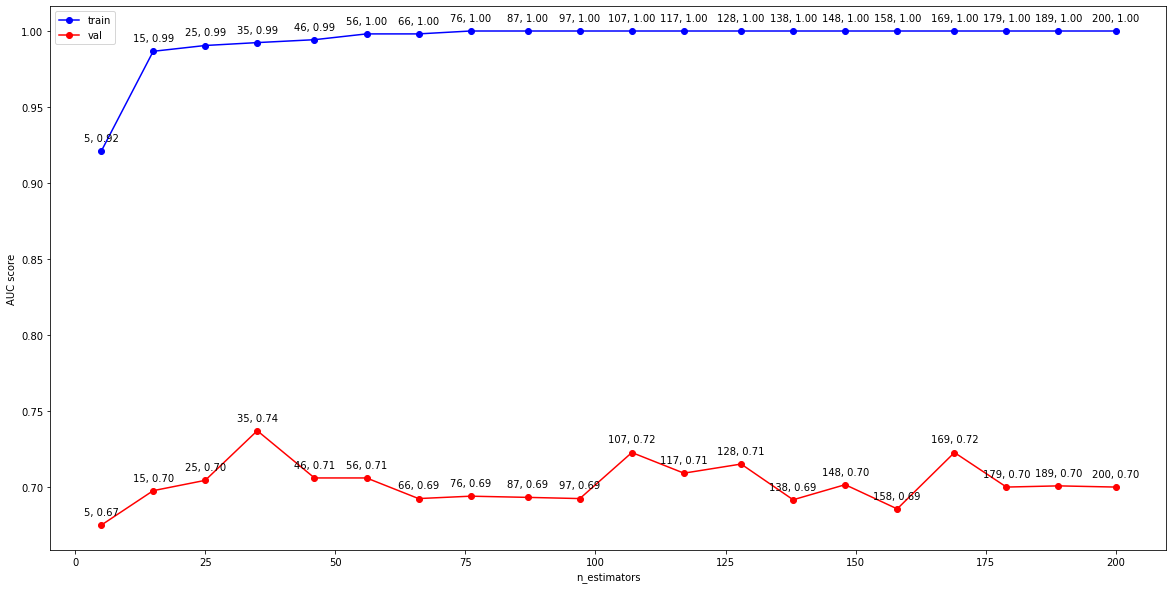

In [38]:
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 200, num = 20)]
train_results = []
val_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    roc_auc_train,roc_auc_val = generate_parameter_score(rf)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(n_estimators,'n_estimators',train_results,val_results)

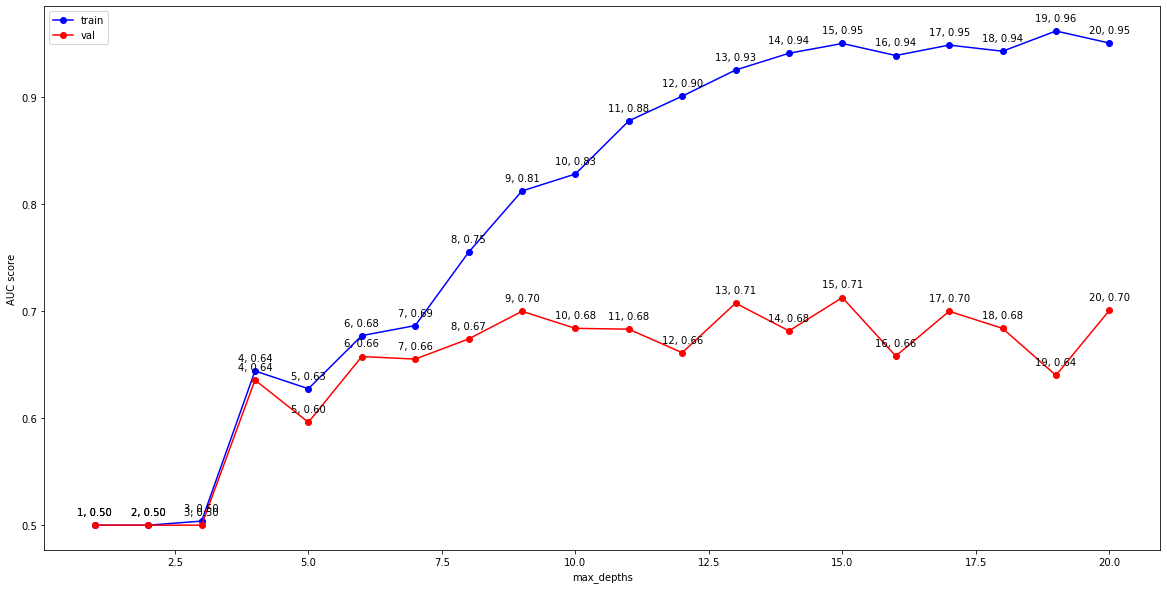

In [39]:
max_depths = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
train_results = []
val_results = []
for depth in max_depths:
    rf = RandomForestClassifier(max_depth=depth, n_jobs=-1)
    roc_auc_train,roc_auc_val = generate_parameter_score(rf)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(max_depths,'max_depths',train_results,val_results)

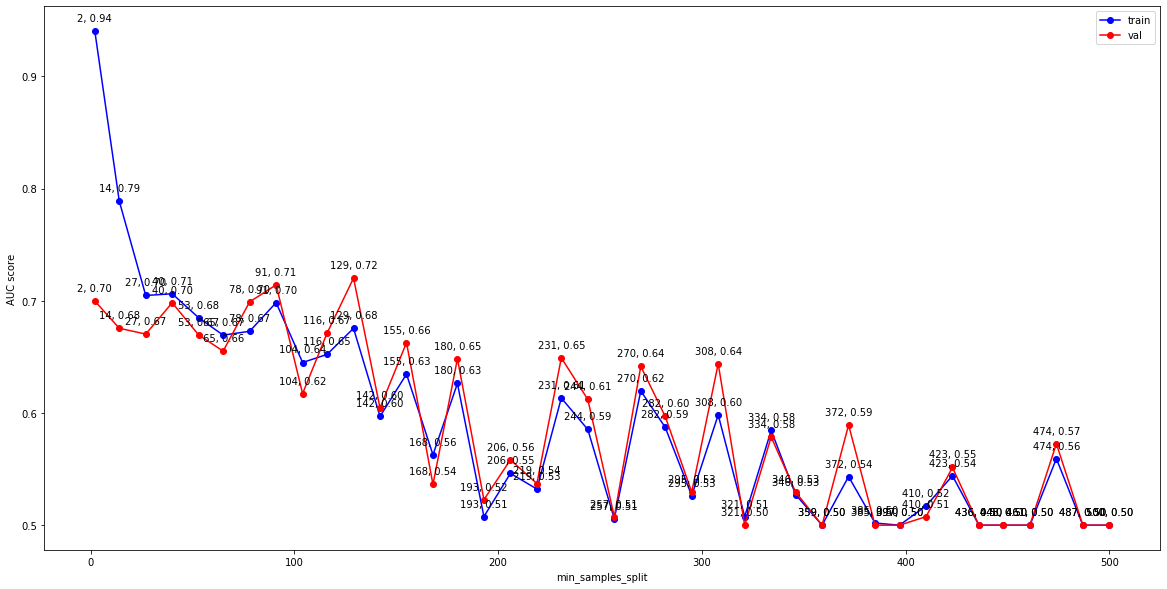

In [40]:
min_samples_splits = [int(x) for x in np.linspace(start = 2, stop = 500, num = 40)]
train_results = []
val_results = []
for split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=split, n_jobs=-1)
    roc_auc_train,roc_auc_val = generate_parameter_score(rf)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(min_samples_splits,'min_samples_split',train_results,val_results)

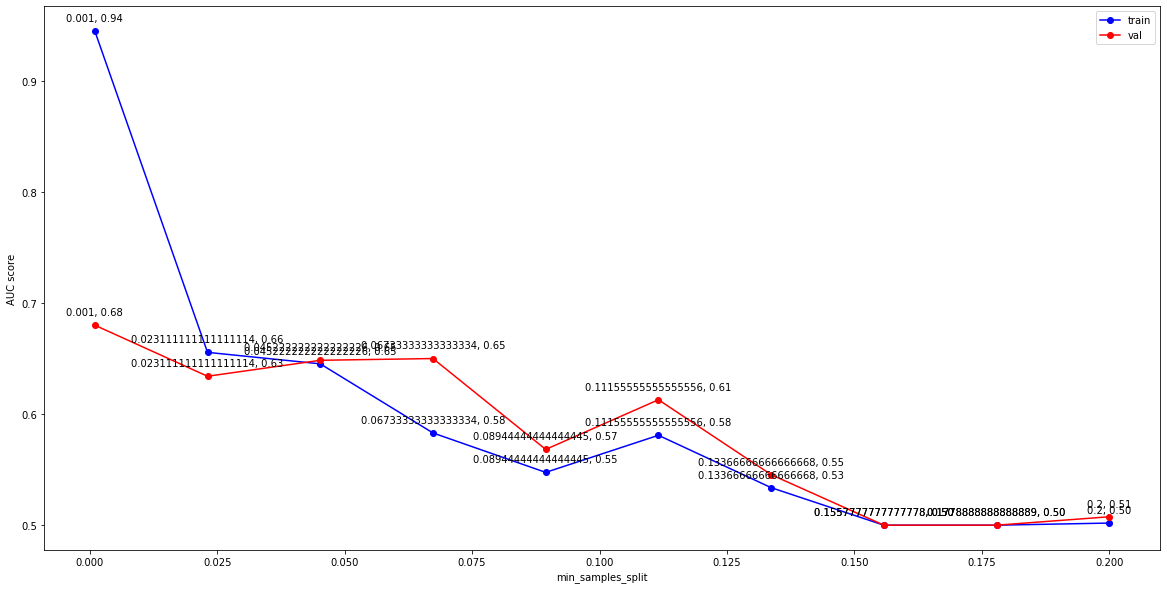

In [41]:
min_samples_splits = np.linspace(0.001, 0.2, 10, endpoint=True)
train_results = []
val_results = []
for split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=split, n_jobs=-1)
    roc_auc_train,roc_auc_val = generate_parameter_score(rf)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(min_samples_splits,'min_samples_split',train_results,val_results)

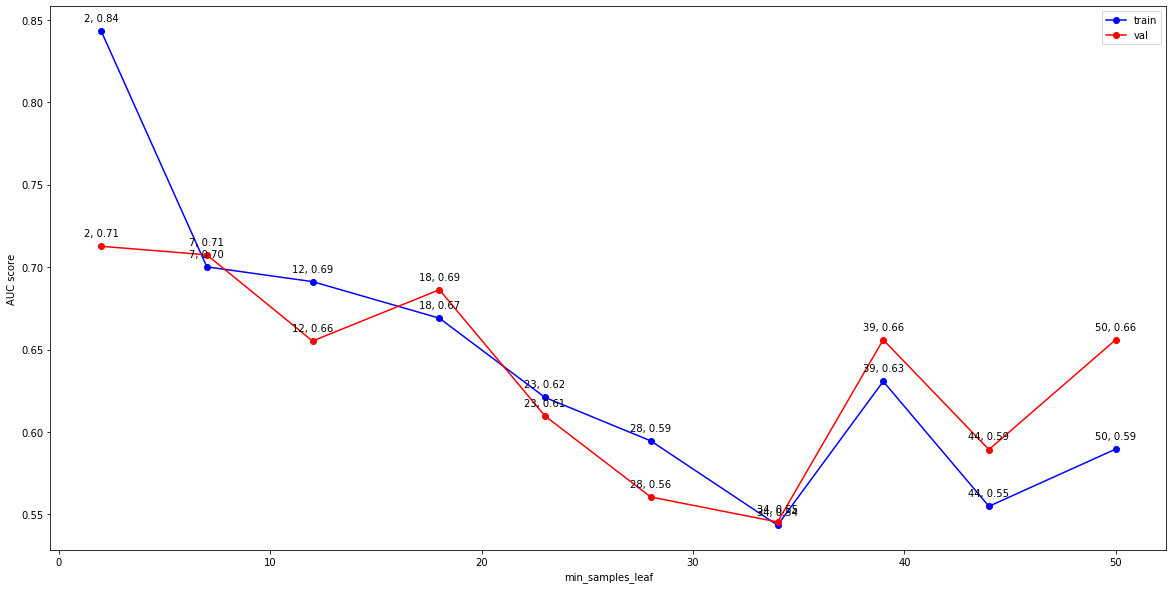

In [42]:
# min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
min_samples_leafs = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)] 
train_results = []
val_results = []
for leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=leaf, n_jobs=-1)
    roc_auc_train,roc_auc_val = generate_parameter_score(rf)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(min_samples_leafs,'min_samples_leaf',train_results,val_results)

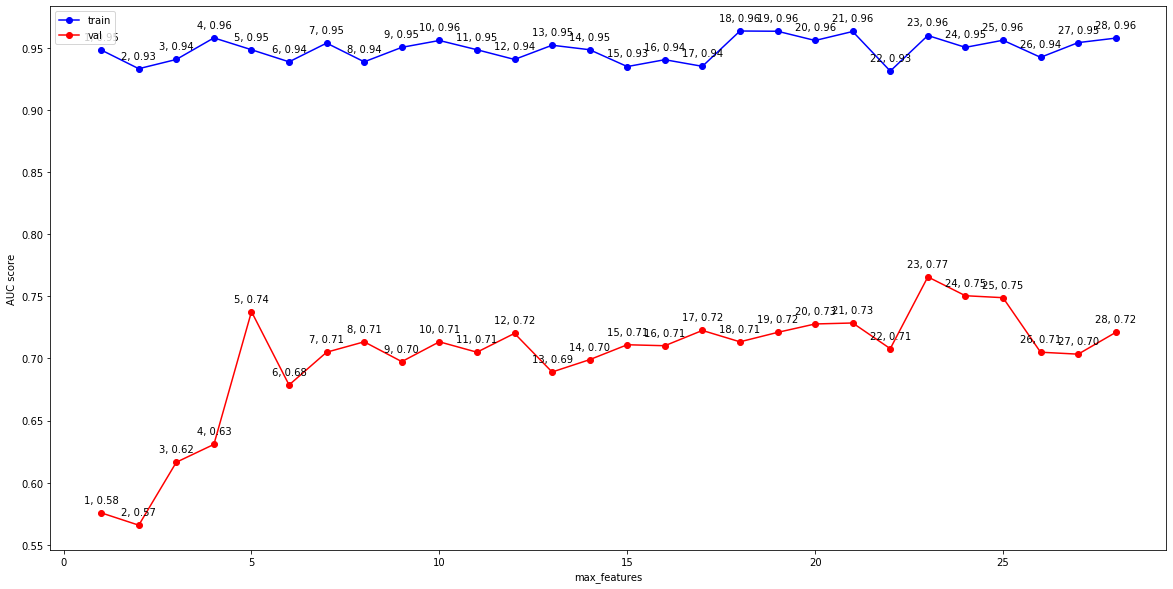

In [43]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
val_results = []
for feature in max_features:
    rf = RandomForestClassifier(max_features=feature, n_jobs=-1)
    roc_auc_train,roc_auc_val = generate_parameter_score(rf)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(max_features,'max_features',train_results,val_results)

In [44]:
# narrow down the parameter search range based on the plots generated
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 20, num = 5)]
max_depths = [int(x) for x in np.linspace(start = 10, stop = 15, num = 5)]
min_samples_splits = np.linspace(0.075, 0.125, 5, endpoint=True)
min_samples_leafs = [int(x) for x in np.linspace(start = 10, stop = 20, num = 5)] 
max_features = list(range(10,X_train.shape[1]))

rf_grid2 = {'rf__max_depth': max_depths,
            'rf__max_features': max_features,
            'rf__min_samples_leaf': min_samples_leafs,
            'rf__min_samples_split': min_samples_splits,
            'rf__n_estimators': n_estimators}

rf = RandomForestClassifier(random_state = 42, criterion= 'gini')
pipeline8 = Pipeline([('sm', sm), ('rf', rf)])
best_rf = hyperparameters(pipeline8, 'random', rf_grid2)
cv(best_rf,X_train_val,y_train_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
accuracy
0.870168031692387
[0.86324786 0.88888889 0.87749288 0.85754986 0.91737892 0.84330484
 0.87749288 0.86285714 0.86532951 0.84813754]
recall
0.6980113636363636
[0.6969697  0.75757576 0.72727273 0.81818182 0.78787879 0.57575758
 0.66666667 0.60606061 0.59375    0.75      ]
precision
0.3953246302716923
[0.37704918 0.44642857 0.4137931  0.38028169 0.54166667 0.31666667
 0.40740741 0.36363636 0.35849057 0.34782609]


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.0s finished


In [47]:
no_cv(best_rf,X_train, y_train, X_val, y_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.0s finished



Train
              precision    recall  f1-score   support

     healthy       0.97      0.88      0.92      2542
mentally ill       0.40      0.76      0.52       262

    accuracy                           0.87      2804
   macro avg       0.68      0.82      0.72      2804
weighted avg       0.92      0.87      0.89      2804

Val
              precision    recall  f1-score   support

     healthy       0.98      0.90      0.94       635
mentally ill       0.48      0.85      0.61        66

    accuracy                           0.90       701
   macro avg       0.73      0.88      0.78       701
weighted avg       0.94      0.90      0.91       701

Logloss: 3.50
roc auc: 0.8762109281794322


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('sm',
                                              SMOTE(k_neighbors=5,
                                                    kind='deprecated',
                                                    m_neighbors='deprecated',
                                                    n_jobs=1,
                                                    out_step='deprecated',
                                                    random_state=42, ratio=None,
                                                    sampling_strategy='auto',
                                                    svm_estimator='deprecated')),
                                             ('rf',
                                              RandomForestClassifier(bootstrap=True,
                                                                     class_weight=None,
               

In [48]:
best_rf_final.best_estimator_

Pipeline(memory=None,
         steps=[('sm',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('rf',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=45,
                                        max_features='log2',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=10,
                                        min_samples_split=20,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=60, n_jobs=None

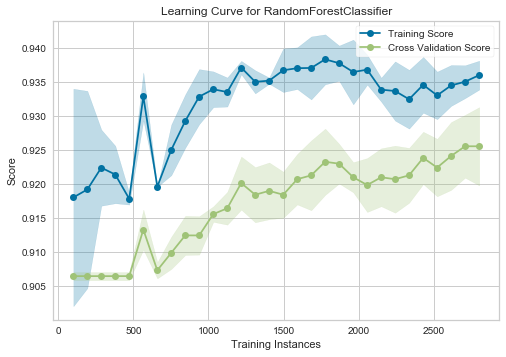

In [52]:
# splitting into 20 diff train sizes
train_sizes = [int(x) for x in np.linspace(start = 100, stop = X_train.shape[0]-1, num = 30)]

# more training entries(row) will not change the results -> more features might
from yellowbrick.model_selection import LearningCurve
visualizer = LearningCurve(best_rf_final.best_estimator_[1], cv=5, scoring='accuracy', train_sizes=train_sizes, n_jobs=4)
visualizer.fit(X_train_val, y_train_val)   
# plt.ylim(0, 1)

visualizer.show()   

## FEATURE SELECTION

In [53]:
pca = PCA(0.9)
principal_components = pca.fit_transform(X_train)
principal_df = pd.DataFrame(data = principal_components)
principal_df.shape

(2804, 13)

In [54]:
def selected_train_val(features):
    selected_X_train = X_train[features]
    selected_X_val = X_val[features]
    selected_X_train_val = X_train_val[features]
    return selected_X_train, selected_X_val, selected_X_train_val

relevant
Diabetes           1.000000
Fasting Glucose    0.447641
Age                0.272656
Exercise           0.175597
Waist Size         0.156855
Name: Diabetes, dtype: float64

irrelevant
['Anemia', 'BMI', 'HDL', 'LDL', 'Pesticide Use', 'Alcohol Use', 'Gender', 'Insulin', 'Leg Length', 'sysBP', 'diaBP', 'BMI_NaN', 'Fasting glucose_NaN', 'LDL_NaN', 'HDL_NaN', 'Insulin_NaN', 'SysBP_NaN', 'DiaBP_NaN', 'Alcohol Use_NaN', 'Mexican American', 'Hispanic', 'White', 'Black', 'Asian', 'Other Race']
['Fasting Glucose', 'Age', 'Exercise', 'Waist Size']


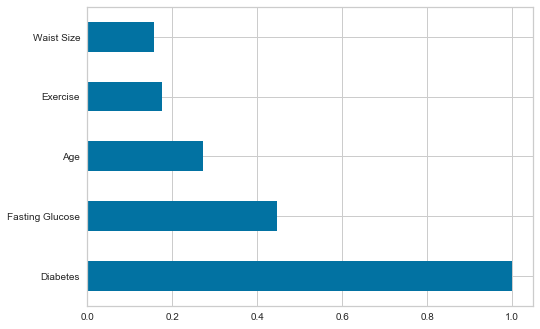

In [58]:
# pearson between numerical variables and y 
correlation_coefficient = 0.15
def feature_target_correlation(df,threshold):
    cor = df.corr()
    cor_target = abs(cor['Diabetes'])
    irrelevant_features = cor_target[cor_target<threshold]
    relevant_features = cor_target[cor_target>threshold].sort_values(ascending=False)
    relevant_features.plot(kind='barh')
    print('relevant')
    print(relevant_features)
    print()
    print('irrelevant')
    print(list(irrelevant_features.index))

    return list(relevant_features.index)[1:]

pearson_num = feature_target_correlation(df,correlation_coefficient)
print(pearson_num)

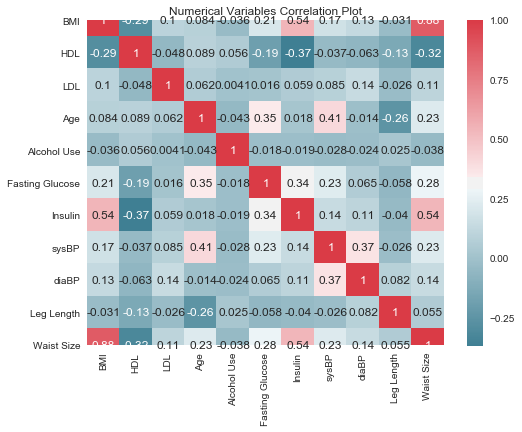

In [59]:
corr_df = df[numerical_variables]
cor = corr_df.corr(method='pearson')
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Numerical Variables Correlation Plot")
# sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
#             square=True, ax=ax, annot=True)
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

plt.show()

#### Attempt 2: selected features using Lasso + logreg
* A regression model that uses L1 regularization technique is called Lasso Regression and model which uses L2 is called Ridge Regression. 

In [60]:
# logreg: default L2
logreg = LogisticRegression()
pipeline2 = Pipeline([('sm', sm), ('logreg', logreg)])
no_cv(pipeline2, X_train, y_train, X_val, y_val)


Train
              precision    recall  f1-score   support

     healthy       0.98      0.83      0.90      2542
mentally ill       0.33      0.81      0.47       262

    accuracy                           0.83      2804
   macro avg       0.65      0.82      0.68      2804
weighted avg       0.92      0.83      0.86      2804

Val
              precision    recall  f1-score   support

     healthy       0.98      0.83      0.90       635
mentally ill       0.33      0.80      0.47        66

    accuracy                           0.83       701
   macro avg       0.65      0.82      0.68       701
weighted avg       0.92      0.83      0.86       701

Logloss: 5.96
roc auc: 0.8164757814364113


Pipeline(memory=None,
         steps=[('sm',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('logreg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [61]:
# lasso
logreg = LogisticRegression(penalty='l1',n_jobs =-1,solver='liblinear')
pipeline3 = Pipeline([('sm', sm), ('logreg', logreg)])
no_cv(pipeline3, X_train, y_train, X_val, y_val)


Train
              precision    recall  f1-score   support

     healthy       0.98      0.83      0.90      2542
mentally ill       0.33      0.81      0.47       262

    accuracy                           0.83      2804
   macro avg       0.65      0.82      0.68      2804
weighted avg       0.92      0.83      0.86      2804

Val
              precision    recall  f1-score   support

     healthy       0.98      0.83      0.90       635
mentally ill       0.33      0.80      0.47        66

    accuracy                           0.83       701
   macro avg       0.65      0.82      0.68       701
weighted avg       0.92      0.83      0.86       701

Logloss: 5.96
roc auc: 0.8164757814364113


Pipeline(memory=None,
         steps=[('sm',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('logreg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=-1, penalty='l1',
                                    random_state=None, solver='liblinear',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [62]:
grid = {'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
best_logreg = hyperparameters(pipeline3, 'gridsearch', grid)
no_cv(best_logreg,X_train, y_train, X_val, y_val)


Train
              precision    recall  f1-score   support

     healthy       0.98      0.83      0.90      2542
mentally ill       0.33      0.82      0.47       262

    accuracy                           0.83      2804
   macro avg       0.65      0.83      0.68      2804
weighted avg       0.92      0.83      0.86      2804

Val
              precision    recall  f1-score   support

     healthy       0.98      0.83      0.90       635
mentally ill       0.33      0.82      0.47        66

    accuracy                           0.83       701
   macro avg       0.66      0.82      0.69       701
weighted avg       0.92      0.83      0.86       701

Logloss: 5.91
roc auc: 0.824051539012169


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sm',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=42, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('logreg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                      

In [63]:
cv(best_logreg,X_train_val,y_train_val)

accuracy
0.8228134037245786
[0.82051282 0.83190883 0.84045584 0.8034188  0.84900285 0.81481481
 0.82621083 0.80857143 0.81948424 0.81375358]
recall
0.7955492424242424
[0.84848485 0.87878788 0.78787879 0.87878788 0.75757576 0.78787879
 0.75757576 0.72727273 0.75       0.78125   ]
precision
0.32186812282509386
[0.32941176 0.3452381  0.34666667 0.3125     0.35714286 0.30952381
 0.32051282 0.29268293 0.30379747 0.30120482]


In [64]:
pipeline4 = Pipeline([('sm', sm), ('pca',pca),('logreg', logreg)])
best_logreg = hyperparameters(pipeline3, 'gridsearch', grid)
cv(best_logreg,X_train_val,y_train_val)

accuracy
0.8230983040094788
[0.82336182 0.83190883 0.84045584 0.8034188  0.84900285 0.81481481
 0.82621083 0.80857143 0.81948424 0.81375358]
recall
0.7955492424242424
[0.84848485 0.87878788 0.78787879 0.87878788 0.75757576 0.78787879
 0.75757576 0.72727273 0.75       0.78125   ]
precision
0.3214691866548811
[0.32941176 0.3452381  0.34666667 0.30851064 0.35714286 0.30952381
 0.32051282 0.29268293 0.30379747 0.30120482]


#### Attempt 3: knn



In [65]:
knn = KNeighborsClassifier()
pipeline5 = Pipeline([('sm', sm),('knn', knn)])
no_cv(pipeline5, X_train, y_train, X_val, y_val)


Train
              precision    recall  f1-score   support

     healthy       1.00      0.86      0.93      2542
mentally ill       0.43      1.00      0.60       262

    accuracy                           0.87      2804
   macro avg       0.71      0.93      0.76      2804
weighted avg       0.95      0.87      0.90      2804

Val
              precision    recall  f1-score   support

     healthy       0.97      0.83      0.89       635
mentally ill       0.30      0.71      0.42        66

    accuracy                           0.82       701
   macro avg       0.63      0.77      0.66       701
weighted avg       0.90      0.82      0.85       701

Logloss: 6.31
roc auc: 0.7702338344070627


Pipeline(memory=None,
         steps=[('sm',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

* small k: low bias, high variance; large k: high bias, low variance

In [66]:
knn_grid =  {'knn__metric': ['euclidean','manhattan'],
             'knn__weights': ['uniform','distance'],
             'knn__n_neighbors': [3,4,5,7,10,15,20]}
best_knn = hyperparameters(pipeline5,'gridsearch',knn_grid)

In [67]:
no_cv(best_knn, X_train, y_train, X_val, y_val)


Train
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00      2542
mentally ill       1.00      1.00      1.00       262

    accuracy                           1.00      2804
   macro avg       1.00      1.00      1.00      2804
weighted avg       1.00      1.00      1.00      2804

Val
              precision    recall  f1-score   support

     healthy       0.97      0.84      0.90       635
mentally ill       0.33      0.76      0.46        66

    accuracy                           0.83       701
   macro avg       0.65      0.80      0.68       701
weighted avg       0.91      0.83      0.86       701

Logloss: 5.72
roc auc: 0.8000477213075639


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sm',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=42, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                   

In [68]:
pipeline6 = Pipeline([('sm', sm),('pca',pca),('knn', knn)])
best_knn = hyperparameters(pipeline6,'gridsearch',knn_grid)
no_cv(best_knn, X_train, y_train, X_val, y_val)


Train
              precision    recall  f1-score   support

     healthy       1.00      0.92      0.96      2542
mentally ill       0.57      1.00      0.73       262

    accuracy                           0.93      2804
   macro avg       0.79      0.96      0.84      2804
weighted avg       0.96      0.93      0.94      2804

Val
              precision    recall  f1-score   support

     healthy       0.95      0.86      0.90       635
mentally ill       0.31      0.61      0.41        66

    accuracy                           0.83       701
   macro avg       0.63      0.73      0.66       701
weighted avg       0.89      0.83      0.86       701

Logloss: 5.72
roc auc: 0.7321641612980195


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sm',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=42, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=0.9, random_state=Non...
                                                             leaf_size=30,
                                                             metric='minkowski',
                                   

In [69]:
cv(best_knn, X_train_val, y_train_val)

accuracy
0.8341947117935656
[0.85754986 0.86609687 0.82336182 0.84330484 0.84330484 0.86324786
 0.82336182 0.82       0.7765043  0.8252149 ]
recall
0.640625
[0.54545455 0.60606061 0.63636364 0.87878788 0.66666667 0.6969697
 0.42424242 0.54545455 0.75       0.65625   ]
precision
0.31480852780668167
[0.33962264 0.37037037 0.29577465 0.3625     0.33333333 0.37704918
 0.24561404 0.27272727 0.25531915 0.29577465]


#### Attempt 4: XGBoost


In [92]:
xgb1 = XGBClassifier()
pipeline7 = Pipeline([('sm', sm),('xgb1', xgb1)])
no_cv(pipeline7, X_train.values, y_train.values, X_val.values, y_val.values)



Train
              precision    recall  f1-score   support

     healthy       0.97      0.96      0.97      2542
mentally ill       0.67      0.68      0.67       262

    accuracy                           0.94      2804
   macro avg       0.82      0.82      0.82      2804
weighted avg       0.94      0.94      0.94      2804

Val
              precision    recall  f1-score   support

     healthy       0.96      0.95      0.95       635
mentally ill       0.55      0.61      0.58        66

    accuracy                           0.92       701
   macro avg       0.75      0.78      0.76       701
weighted avg       0.92      0.92      0.92       701

Logloss: 2.91
roc auc: 0.777046051061799


Pipeline(memory=None,
         steps=[('sm',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('xgb1',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                      

In [93]:
xgb_grid =  {'xgb1__min_child_weight': [1, 5, 10],
             'xgb1__gamma': [0.5, 1, 1.5, 2, 5],
             'xgb1__subsample': [0.6, 0.8, 1.0],
             'xgb1__colsample_bytree': [0.6, 0.8, 1.0],
             'xgb1__max_depth': [3, 4, 5]}
best_xgb1 = hyperparameters(pipeline7,'random',xgb_grid)

In [94]:
best_xgb1 = no_cv(best_xgb1, X_train.values, y_train.values, X_val.values, y_val.values)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.0s finished



Train
              precision    recall  f1-score   support

     healthy       0.98      0.99      0.98      2542
mentally ill       0.85      0.76      0.80       262

    accuracy                           0.97      2804
   macro avg       0.91      0.87      0.89      2804
weighted avg       0.96      0.97      0.96      2804

Val
              precision    recall  f1-score   support

     healthy       0.96      0.96      0.96       635
mentally ill       0.63      0.59      0.61        66

    accuracy                           0.93       701
   macro avg       0.79      0.78      0.79       701
weighted avg       0.93      0.93      0.93       701

Logloss: 2.46
roc auc: 0.7773443092340729


In [95]:
best_xgb = best_xgb1.best_estimator_[1]

feature importance
Exercise               0.141161
Fasting Glucose        0.124609
Age                    0.086639
Mexican American       0.048883
White                  0.047275
Hispanic               0.042935
SysBP_NaN              0.041189
HDL_NaN                0.040477
Gender                 0.039735
Black                  0.039008
Alcohol Use_NaN        0.036759
Pesticide Use          0.031038
Anemia                 0.030020
LDL                    0.026538
Alcohol Use            0.022845
Fasting glucose_NaN    0.022144
Asian                  0.020466
HDL                    0.017310
Insulin                0.016981
sysBP                  0.016373
LDL_NaN                0.016168
DiaBP_NaN              0.015170
Leg Length             0.014851
diaBP                  0.014174
Waist Size             0.014026
BMI                    0.011944
Other Race             0.011531
Insulin_NaN            0.009750
BMI_NaN                0.000000
dtype: float32


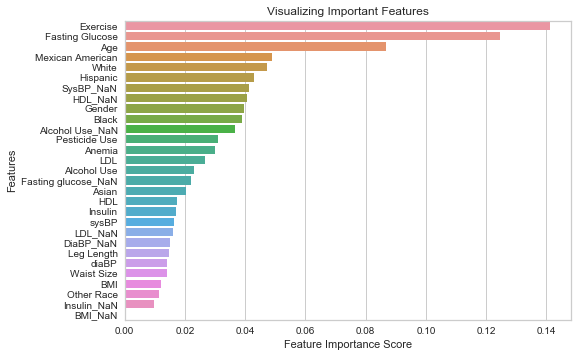

Exercise               0.141161
Fasting Glucose        0.124609
Age                    0.086639
Mexican American       0.048883
White                  0.047275
Hispanic               0.042935
SysBP_NaN              0.041189
HDL_NaN                0.040477
Gender                 0.039735
Black                  0.039008
Alcohol Use_NaN        0.036759
Pesticide Use          0.031038
Anemia                 0.030020
LDL                    0.026538
Alcohol Use            0.022845
Fasting glucose_NaN    0.022144
Asian                  0.020466
HDL                    0.017310
Insulin                0.016981
sysBP                  0.016373
LDL_NaN                0.016168
DiaBP_NaN              0.015170
Leg Length             0.014851
diaBP                  0.014174
Waist Size             0.014026
BMI                    0.011944
Other Race             0.011531
Insulin_NaN            0.009750
BMI_NaN                0.000000
dtype: float32

In [96]:
feature_importance(best_xgb,X_names)

In [105]:
cv(best_xgb1, X_train_val.as_matrix(), y_train_val.as_matrix())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.1s finished


accuracy
0.9223806678305246
[0.91737892 0.93732194 0.93162393 0.93162393 0.94586895 0.9031339
 0.92592593 0.90571429 0.89971347 0.92550143]
recall
0.5363636363636364
[0.54545455 0.54545455 0.51515152 0.72727273 0.57575758 0.48484848
 0.48484848 0.48484848 0.4375     0.5625    ]
precision
0.6046012670125573
[0.5625     0.72       0.68       0.61538462 0.79166667 0.48484848
 0.64       0.5        0.4516129  0.6       ]


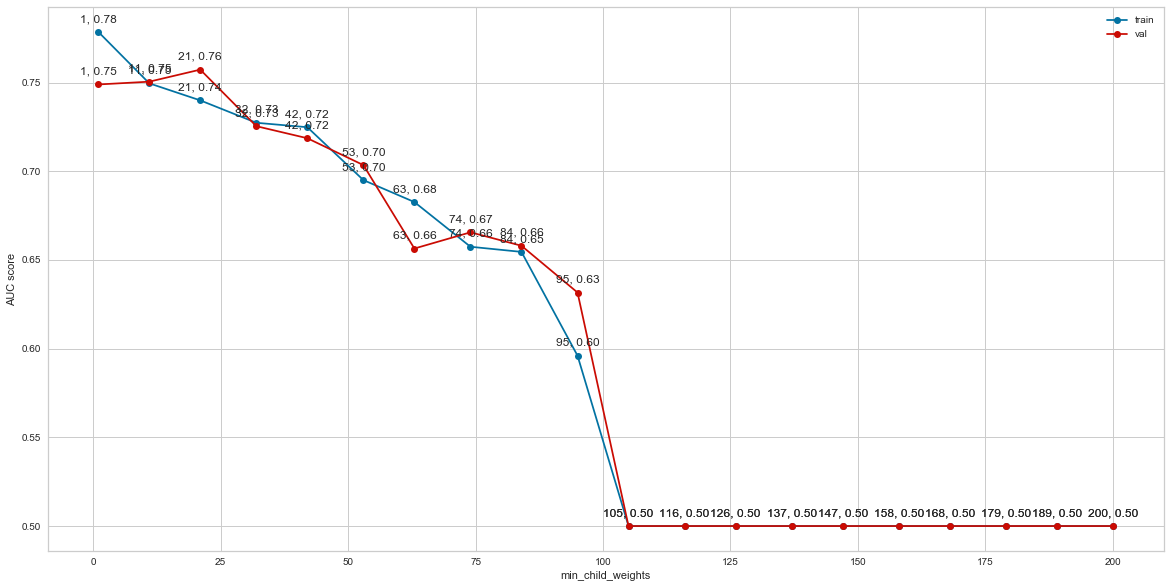

In [98]:
min_child_weights = [int(x) for x in np.linspace(start = 1, stop = 200, num = 20)] 
train_results = []
val_results = []
for weight in min_child_weights:
    xgb = XGBClassifier(min_child_weight=weight)
    roc_auc_train,roc_auc_val = generate_parameter_score(xgb)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(min_child_weights,'min_child_weights',train_results,val_results)

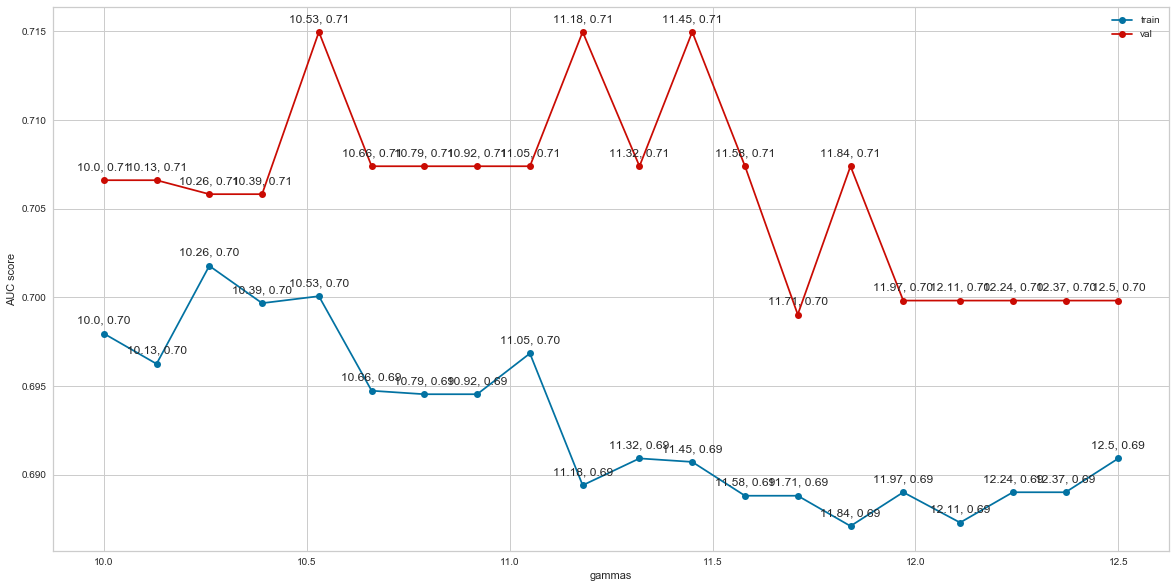

In [99]:
gammas = [round(x,2) for x in np.linspace(start = 10, stop = 12.5, num = 20)] 
train_results = []
val_results = []
for gamma in gammas:
    xgb = XGBClassifier(gamma=gamma)
    roc_auc_train,roc_auc_val = generate_parameter_score(xgb)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(gammas,'gammas',train_results,val_results)

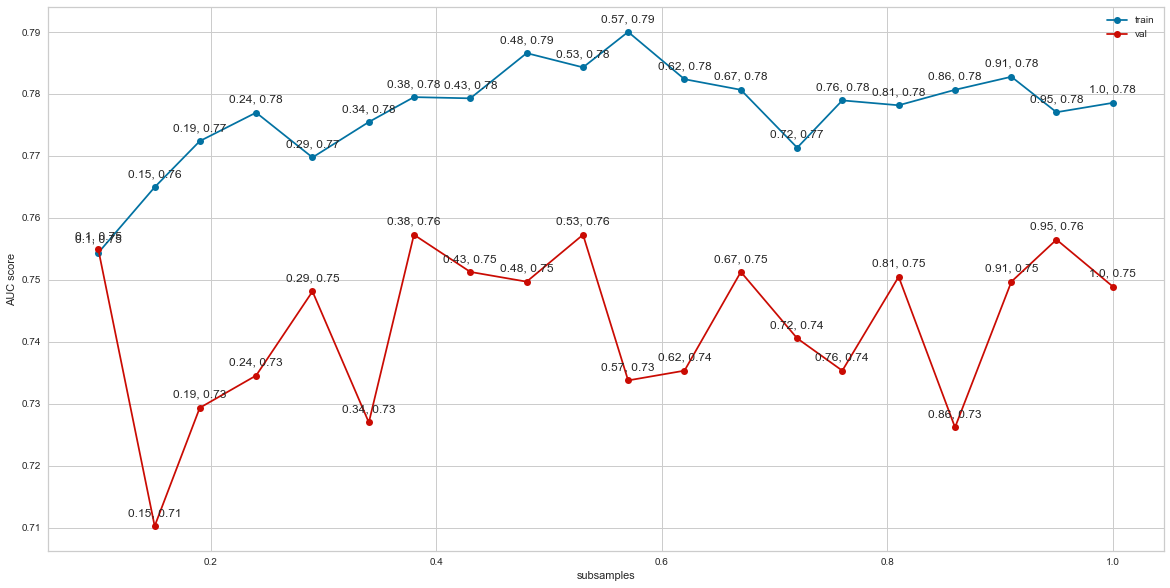

In [100]:
subsamples = [round(x,2) for x in np.linspace(start = 0.1, stop = 1, num = 20)] 
train_results = []
val_results = []
for subsample in subsamples:
    xgb = XGBClassifier(subsample=subsample)
    roc_auc_train,roc_auc_val = generate_parameter_score(xgb)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(subsamples,'subsamples',train_results,val_results)

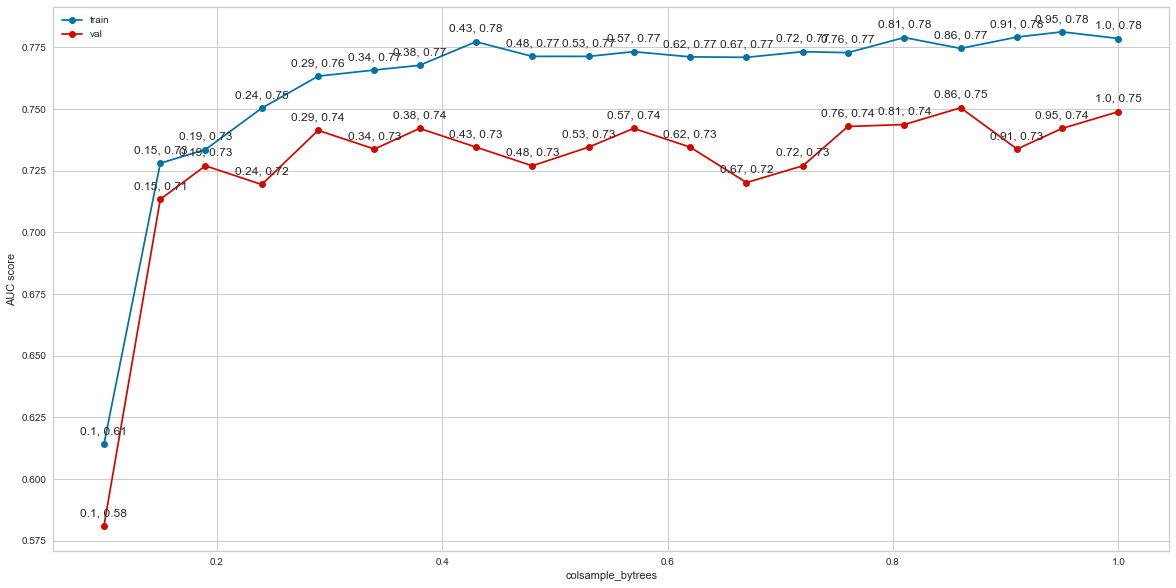

In [101]:
colsample_bytrees = [round(x,2) for x in np.linspace(start = 0.1, stop = 1, num = 20)] 
train_results = []
val_results = []
for colsample_bytree in colsample_bytrees:
    xgb = XGBClassifier(colsample_bytree=colsample_bytree)
    roc_auc_train,roc_auc_val = generate_parameter_score(xgb)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(colsample_bytrees,'colsample_bytrees',train_results,val_results)

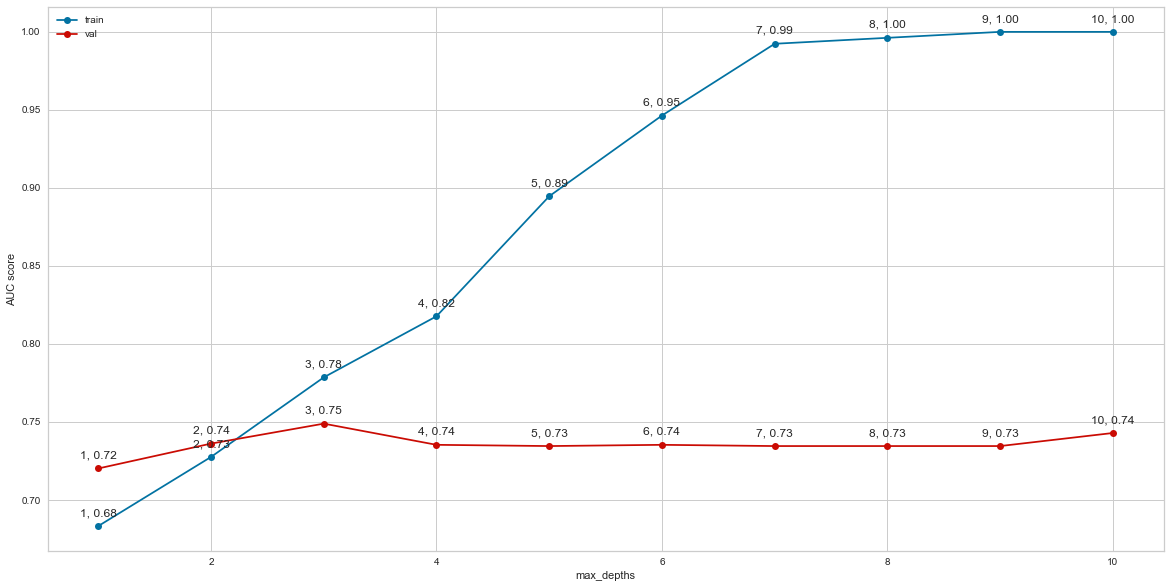

In [103]:
max_depths = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)] 
train_results = []
val_results = []
for max_depth in max_depths:
    xgb = XGBClassifier(max_depth=max_depth)
    roc_auc_train,roc_auc_val = generate_parameter_score(xgb)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(max_depths,'max_depths',train_results,val_results)

In [106]:
xgb_grid2 = {'xgb1__min_child_weight': [i for i in range(0,25)],
             'xgb1__gamma': [round(x,2) for x in np.linspace(start = 10, stop = 10.5, num = 5)],
             'xgb1__subsample': [0.2,0.3,0.4],
             'xgb1__colsample_bytree': [0.2,0.3,0.4,0.5,0.6],
             'xgb1__max_depth': [1,2,3, 4, 5]}
best_xgb2 = hyperparameters(pipeline7,'random',xgb_grid2)

In [107]:
cv(best_xgb2, X_train_val.values, y_train_val.values)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.8s finished


accuracy
0.9098336452892327
[0.92022792 0.92307692 0.91168091 0.90883191 0.93162393 0.88603989
 0.91737892 0.88285714 0.88538682 0.93123209]
recall
0.5728219696969697
[0.60606061 0.63636364 0.48484848 0.78787879 0.60606061 0.54545455
 0.57575758 0.45454545 0.46875    0.5625    ]
precision
0.5252819457628671
[0.57142857 0.58333333 0.53333333 0.50980392 0.64516129 0.41860465
 0.55882353 0.39473684 0.39473684 0.64285714]


In [118]:
best_xgb = best_xgb1.best_estimator_[1]

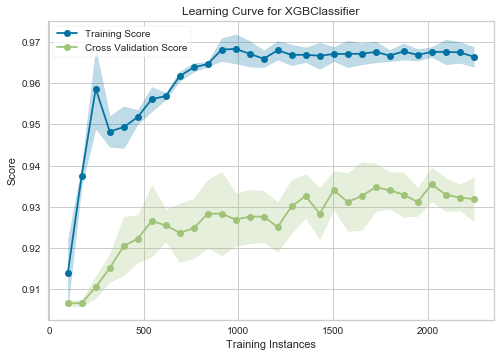

In [119]:
train_sizes = [int(x) for x in np.linspace(start = 100, stop = 2242, num = 30)]
visualizer = LearningCurve(best_xgb, cv=5, scoring='accuracy', train_sizes=train_sizes, n_jobs=4)
visualizer.fit(X_train, y_train)        
visualizer.show()   

#### Attempt 5: SVM

In [88]:
svc = SVC(probability=True)
pipeline8 = Pipeline([('sm', sm),('svc', svc)])
no_cv(pipeline8, X_train, y_train, X_val, y_val)


Train
              precision    recall  f1-score   support

     healthy       0.99      0.88      0.93      2542
mentally ill       0.44      0.91      0.60       262

    accuracy                           0.88      2804
   macro avg       0.72      0.90      0.76      2804
weighted avg       0.94      0.88      0.90      2804

Val
              precision    recall  f1-score   support

     healthy       0.97      0.86      0.91       635
mentally ill       0.36      0.74      0.49        66

    accuracy                           0.85       701
   macro avg       0.67      0.80      0.70       701
weighted avg       0.91      0.85      0.87       701

Logloss: 5.12
roc auc: 0.8027081842042472


Pipeline(memory=None,
         steps=[('sm',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('svc',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=True, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [90]:
Cs = [0.001, 0.01, 0.1, 1, 10,100]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['linear', 'rbf', 'poly']
svc_grid =  {'svc__C': Cs,
             'svc__gamma': gammas,
             'svc__kernel': kernels}
best_svc = hyperparameters(pipeline8,'random',svc_grid)

In [91]:
cv(best_svc, X_train_val, y_train_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   58.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   58.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   57.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   58.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   59.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   57.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   57.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   59.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   57.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   56.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   54.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   57.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   54.5s finished


accuracy
0.9067062541618416
[0.90598291 0.90598291 0.90598291 0.90598291 0.90883191 0.90598291
 0.90598291 0.90571429 0.90830946 0.90830946]
recall
0.0030303030303030303
[0.         0.         0.         0.         0.03030303 0.
 0.         0.         0.         0.        ]
precision
0.1
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
